# Financial Modeling of Carbon Shipping Costs From European Ports to American Ports

## Import and Procedural Functions

In [268]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import contextily as cx
import rtree
from zlib import crc32
import hashlib
from shapely.geometry import Point, LineString, Polygon
import numpy as np
from scipy.spatial import cKDTree
from shapely.geometry import Point
from haversine import Unit
from geopy.distance import distance

import warnings

In [269]:


warnings.filterwarnings('ignore')

In [265]:
SHAPELY_GE_20 = str(shapely.__version__) >= LooseVersion("2.0")

try:
    from shapely.errors import ShapelyDeprecationWarning as shapely_warning
except ImportError:
    shapely_warning = None

if shapely_warning is not None and not SHAPELY_GE_20:
    @contextlib.contextmanager
    def ignore_shapely2_warnings():
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=shapely_warning)
            yield
else:
    @contextlib.contextmanager
    def ignore_shapely2_warnings():
        yield


/var/folders/kw/lt24g6yd1ml1zznc5n22lbb00000gn/T/ipykernel_3054/403662426.py:1: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  SHAPELY_GE_20 = str(shapely.__version__) >= LooseVersion("2.0")


## Data Frame Import

### Filtered Wells DataFrame

In [36]:
## Importing our DataFrames

gisfilepath = "/Users/jnapolitano/Projects/data/energy/filtered-wells.geojson"


filtered_df = gpd.read_file(gisfilepath)

filtered_df = filtered_df.to_crs(epsg=3857)



In [37]:
filtered_df.head()


,index,OBJECTID_left,ID,NAME_left,STATE_left,TYPE_left,STATUS_left,COUNTY_left,COUNTYFIPS_left,COUNTRY_left,...,STORCAP,CURRENTCAP,APPCAP,OPYEAR,IMPEXPCTRY,VOLUME,PRICE,distance_euclidian,true_distance_km,geometry
0,71180,71181,W220071181,SL 17397,LA,OIL & NATURAL GAS WELL,NON-ACTIVE WELL,ST BERNARD,22087,USA,...,7.5,1.5,-999.0,2011,NOT APPLICABLE,0.0,0.0,82463.214796,71.208145,POINT (-9904799.748 3481625.484)
1,391586,391587,W010000295,NOT AVAILABLE,AL,OIL & NATURAL GAS WELL,NON-ACTIVE WELL,NOT AVAILABLE,NOT AVAILABLE,USA,...,7.5,1.5,-999.0,2011,NOT APPLICABLE,0.0,0.0,60759.986301,52.507422,POINT (-9793591.577 3528758.474)
2,391587,391588,W010000296,NOT AVAILABLE,AL,OIL & NATURAL GAS WELL,NON-ACTIVE WELL,NOT AVAILABLE,NOT AVAILABLE,USA,...,7.5,1.5,-999.0,2011,NOT APPLICABLE,0.0,0.0,50965.923934,44.039924,POINT (-9801928.294 3536226.961)
3,391588,391589,W010000297,NOT AVAILABLE,AL,OIL & NATURAL GAS WELL,NON-ACTIVE WELL,NOT AVAILABLE,NOT AVAILABLE,USA,...,7.5,1.5,-999.0,2011,NOT APPLICABLE,0.0,0.0,44714.785732,38.630789,POINT (-9810237.179 3529412.773)
4,135738,135739,W220135739,SL 8191,LA,OIL & NATURAL GAS WELL,NON-ACTIVE WELL,ST BERNARD,22087,USA,...,7.5,1.5,-999.0,2011,NOT APPLICABLE,0.0,0.0,110496.059714,95.476188,POINT (-9915262.667 3454391.388)


In [38]:
filtered_df.columns

Index(['index', 'OBJECTID_left', 'ID', 'NAME_left', 'STATE_left', 'TYPE_left',
       'STATUS_left', 'COUNTY_left', 'COUNTYFIPS_left', 'COUNTRY_left',
       'LATITUDE_left', 'LONGITUDE_left', 'NAICS_CODE_left', 'NAICS_DESC_left',
       'SOURCE_left', 'SOURCEDATE_left', 'VAL_METHOD_left', 'VAL_DATE_left',
       'WEBSITE_left', 'WELLIDNO', 'API', 'PERMITNO', 'OPERATOR', 'OPERATORID',
       'PRODTYPE', 'COORDTYPE', 'SURF_LAT', 'SURF_LONG', 'BOT_LAT', 'BOT_LONG',
       'POSREL_left', 'FIELD', 'COMPDATE', 'TOTDEPTH', 'STAUTS_CAT',
       'index_right', 'OBJECTID_right', 'TERMID', 'NAME_right', 'ADDRESS',
       'CITY', 'STATE_right', 'ZIP', 'ZIP4', 'TELEPHONE', 'TYPE_right',
       'STATUS_right', 'POPULATION', 'COUNTY_right', 'COUNTYFIPS_right',
       'COUNTRY_right', 'LATITUDE_right', 'LONGITUDE_right',
       'NAICS_CODE_right', 'NAICS_DESC_right', 'SOURCE_right',
       'SOURCEDATE_right', 'VAL_METHOD_right', 'VAL_DATE_right',
       'WEBSITE_right', 'EPA_ID', 'ALT_NAME', 'OWNER',

## INclude cost by facility type

## Cost for onshore facility 

in euro 2009.  Convert to us 2022

https://www.sciencedirect.com/science/article/pii/S1750583615001814?via%3Dihub#bib0330

assume the highest range at 1.49 https://www.statista.com/statistics/412794/euro-to-u-s-dollar-annual-average-exchange-rate/

$1 in 2009 is equivalent in purchasing power to about $1.34 today,
https://www.in2013dollars.com/us/inflation/2009?amount=1

conversion is equal (euro * 1.49) * 1.34


Depleted O&G Field – reusing wells	Onshore	1	3	7  
Saline Formations	Onshore	2	5	12
Depleted O&G Field – reusing wells	Offshore	2	6	9
Saline Formations	Offshore	6	14	20

### Convert Oil and Gas Wells to 2022 USD

In [48]:
depleted_og_2009 = (1.0,7.0)
depleted_og_2009_usd = (depleted_og_2009[0] * 1.49, depleted_og_2009[1] * 1.49)
depleted_og_2022_usd = (depleted_og_2009_usd[0] * 1.34, depleted_og_2009_usd[1] * 1.49)
depleted_og_2022_usd


(1.9966000000000002, 15.5407)

### Convert Saline Formations to 2022 USD


In [49]:
depleted_saline_2009 = (2.0,12.0)
depleted_saline_2009_usd = (depleted_saline_2009[0] * 1.49, depleted_saline_2009[1] * 1.49)
depleted_saline_2022_usd = (depleted_saline_2009_usd[0] * 1.34, depleted_saline_2009_usd[1] * 1.49)
depleted_saline_2022_usd

(3.9932000000000003, 26.641199999999998)

## Include Price Ranges in the Wells Dataset

In [50]:
## Adding temp collumns
filtered_df['cost_storage_low'] = 0
filtered_df['cost_storage_high'] = 0

In [52]:
# Checking for value types
filtered_df['TYPE_left'].unique()

array(['OIL & NATURAL GAS WELL'], dtype=object)

In [53]:
# Despite only having one i am conditionally vectorizing the function

filtered_df.loc[filtered_df['TYPE_left'] == 'OIL & NATURAL GAS WELL', "cost_storage_low"] = depleted_og_2022_usd[0]

filtered_df['cost_storage_low']

0       1.9966
1       1.9966
2       1.9966
3       1.9966
4       1.9966
         ...  
4375    1.9966
4376    1.9966
4377    1.9966
4378    1.9966
4379    1.9966
Name: cost_storage_low, Length: 4380, dtype: float64

In [55]:
##Conditional for high

filtered_df.loc[filtered_df['TYPE_left'] == 'OIL & NATURAL GAS WELL', "cost_storage_high"] = depleted_og_2022_usd[1]
filtered_df.cost_storage_high

0       15.5407
1       15.5407
2       15.5407
3       15.5407
4       15.5407
         ...   
4375    15.5407
4376    15.5407
4377    15.5407
4378    15.5407
4379    15.5407
Name: cost_storage_high, Length: 4380, dtype: float64

In [65]:
filtered_df.CURRENTCAP

0       1.5
1       1.5
2       1.5
3       1.5
4       1.5
       ... 
4375    4.0
4376    4.0
4377    4.0
4378    4.0
4379    4.0
Name: CURRENTCAP, Length: 4380, dtype: float64

## Convert Capacity of Natural Gas to Carbon  

Unit is millions of metric tons per annum.  This must be converted to volume.  That volume of container must then be used to calculate the volume of co2 that it can hold.  Then convert that volume back to metric tonnes.  

### Conversion factors

1 tonne co2 super critical = 2.64812 meter cubed super critical co2

1 tonnes LNG = 2.21 m3 LNG (liquid) 


### Conversion

deduct a percentage





In [69]:
conversion_factor = 2.21/2.65
conversion_factor

0.8339622641509434

In [70]:
filtered_df['current_cap_co2sc'] = filtered_df['CURRENTCAP'] * conversion_factor
filtered_df['current_cap_co2sc']

0       1.250943
1       1.250943
2       1.250943
3       1.250943
4       1.250943
          ...   
4375    3.335849
4376    3.335849
4377    3.335849
4378    3.335849
4379    3.335849
Name: current_cap_co2sc, Length: 4380, dtype: float64

## Carrying Capacity of Ships

40,000 m3 71,500 to 210,000  to 266,000

a global average of about 70,000 m3 


In [73]:
co2_capacity_per_ship = 70000 * conversion_factor
co2_capacity_per_ship

58377.35849056604

1 tonne co2 = 544.66

### Co2 Capacity Per ship

In [75]:
co2_capacity_per_ship_tonnes = co2_capacity_per_ship/544.66
co2_capacity_per_ship_tonnes

107.18128463732612

## Designing the Simulation

## The Tables

Create a port table with maximums 
Deduct from the maximums at a random rate. 10-20 days per ship in circulation of 642*.25
    Maintain a table with each ship.  When counter reaches 0 reset at a random rate between 20-40 days for a round trip
    evenly distribute the range.  It will need to be adapted to actual data tables if i can find them

    Calculate cost of transport for shipping.  Find this data online

Randomly select spent well within 100 km of a port
Calculate cost of tranport via pipeline from randomly distributed range 
    with better data deduct values from estimated capacity.. Or just use the average from the atlas.  That is better than nothing 

summate the cost of each transaction perr annum.  


Currently i have the port data
i have the well data

I must randomize a shipping table with rough estimatios for now 


### The simulation

What is the global market like?  How many tonnes of carbon should i expect?  I'll create the simulation with some random large number to begin.  With better data I will improve the estimates.  


Every day 

co2 total - ship distribution

ship randomly  advances to a port
    transport rate per tonne

port capacity reduced upon arrival

capacity of ship randomly sent to a stroage facilty upon arrival
    what is the rate of transport per 100 km?
    tranport cost per tonne

storage rate per tonne per day of tonnage in the well. 

After a year of simulation summate values to calculate annual costs 

Repeat the scenario under a thousand epochs if possible.  











### Shipping Capacities in lng 

431 billion cubic meters in 2018,

93.4 million cubic meters capacity 

642 vessels 


## Creating the tables

### Shipping_Df 

In [94]:
### a rough estimate of global suplly dedicated to co2 shipping

# I will probably need a better metric but this is a good start that can be modified later when necessary

ships = int(63*.25)
ships


15

In [292]:
# Capacity range
# 40,000 m3 71,500 to 210,000

#Susanna Dorigoni, Luigi Mazzei, Federico Pontoni, and Antonio Sileo
#IEFE – Centre for Research on Energy and Environmental Economics and Policy,
#Università Bocconi, Milan, Italy

# I'm sure a better report is available but this is a start
# cubic meters unit

lower_bound = int(40000 * conversion_factor)
upper_bound = int(210000 * conversion_factor)

median = 137564 * conversion_factor
standard_dev = 6.63 * conversion_factor  #file:///Users/jnapolitano/Downloads/LNG_Shipping_a_Descriptive_Analysis.pdf

cap_range = range(lower_bound, upper_bound)

cap_distribution = np.random.normal(loc=median , scale=standard_dev, size=ships)

cap_distribution


array([114715.78031182, 114721.51208428, 114718.8603451 , 114719.97413121,
       114718.83785518, 114723.9330491 , 114726.22836916, 114720.28920027,
       114736.0670295 , 114723.18810718, 114717.64283251, 114719.11708982,
       114722.50342621, 114720.41368433, 114717.15671219])

In [296]:
standard_dev

5.529169811320755

In [259]:
shipping_df = pd.DataFrame(cap_distribution, columns=['co2_capacity_cubic_meters'])
shipping_df['days_to_port'] = 0
shipping_df['europe_port'] = ''
shipping_df["us_port"] =''
shipping_df['distance'] =''
shipping_df['price'] = 0
shipping_df['co2_capacity_tonnes'] = shipping_df['co2_capacity_cubic_meters']/544.66 ## Verify this factor.  It seems to high
shipping_df

,co2_capacity_cubic_meters,days_to_port,europe_port,us_port,distance,price,co2_capacity_tonnes
0,114715.238958,0,,,,0,210.618072
1,114725.570049,0,,,,0,210.637040
2,114724.081340,0,,,,0,210.634306
3,114730.708917,0,,,,0,210.646475
4,114715.415365,0,,,,0,210.618396
5,114716.728764,0,,,,0,210.620807
6,114725.703270,0,,,,0,210.637284
7,114728.980221,0,,,,0,210.643301
8,114720.840068,0,,,,0,210.628355
9,114723.484919,0,,,,0,210.633211


### Port Df

Import the port data

### Terminal DataFrame

In [118]:
map_conditions = filtered_df.TERMID.unique().tolist()

map_conditions



['ANLLNG28001',
 'ANLLNG48003',
 'ANLLNG48004',
 'ANLLNG48002',
 'ANLLNG48001',
 'ANLLNG48005',
 'ANLLNG22006',
 'ANLLNG22002',
 'ANLLNG22004',
 'ANLLNG22005',
 'ANLLNG22007',
 'ANLLNG22001',
 'ANLLNG22003']

### Filtering Ports to those in the Terminal Joined Dataset

In [98]:
## Importing our DataFrames

gisfilepath = "/Users/jnapolitano/Projects/data/energy/Liquified_Natural_Gas_Import_Exports_and_Terminals.geojson"


terminal_df = gpd.read_file(gisfilepath)

terminal_df = terminal_df.to_crs(epsg=3857)



In [99]:
terminal_df.drop(terminal_df[terminal_df['STATUS'] == 'SUSPENDED'].index, inplace = True)
terminal_df.rename(columns={"NAME": "TERMINAL_NAME"})
terminal_df['TERMINAL_GEO'] = terminal_df['geometry'].copy()
terminal_df.columns

Index(['OBJECTID', 'TERMID', 'NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'ZIP4',
       'TELEPHONE', 'TYPE', 'STATUS', 'POPULATION', 'COUNTY', 'COUNTYFIPS',
       'COUNTRY', 'LATITUDE', 'LONGITUDE', 'NAICS_CODE', 'NAICS_DESC',
       'SOURCE', 'SOURCEDATE', 'VAL_METHOD', 'VAL_DATE', 'WEBSITE', 'EPA_ID',
       'ALT_NAME', 'OWNER', 'POSREL', 'JRSDCTN', 'CONTYPE', 'IE_PORT',
       'BERTHS', 'STORAGE', 'STORCAP', 'CURRENTCAP', 'APPCAP', 'OPYEAR',
       'IMPEXPCTRY', 'VOLUME', 'PRICE', 'geometry', 'TERMINAL_GEO'],
      dtype='object')

In [136]:
port_terminals_df = terminal_df.query('TERMID in @map_conditions').copy()

In [137]:
port_terminals_df['co2_capacity_mmta'] = port_terminals_df['CURRENTCAP'] * conversion_factor

In [139]:
port_terminals_df['co2_capacity_metric_tons'] = port_terminals_df['co2_capacity_mmta'] * 1000000

In [141]:
port_terminals_df['available'] = True

In [142]:
port_terminals_df

,OBJECTID,TERMID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,...,APPCAP,OPYEAR,IMPEXPCTRY,VOLUME,PRICE,geometry,TERMINAL_GEO,co2_capacity_mmta,co2_capacity_metric_tons,available
2,3,ANLLNG22001,CAMERON LNG LLC - CAMERON LNG IMPORT FACILITY,301 N MAIN STREET,HACKBERRY,LA,70645,5012,NOT AVAILABLE,IMPORT,...,-999.00,2009,NOT APPLICABLE,0.00,0.00,POINT (-10390170.651 3508359.329),POINT (-10390170.651 3508359.329),1.501132,1.501132e+06,True
3,4,ANLLNG22002,LAKE CHARLES TERMINAL,8100 BIG LAKE ROAD,LAKE CHARLES,LA,70605,0300,NOT AVAILABLE,IMPORT,...,-999.00,1982,NOT APPLICABLE,0.00,0.00,POINT (-10384797.593 3518078.078),POINT (-10384797.593 3518078.078),1.751321,1.751321e+06,True
4,5,ANLLNG22003,SABINE PASS LNG LP - SABINE PASS LNG IMPORT TE...,9243 GULF BEACH HIGHWAY,CAMERON,LA,70631,4019,NOT AVAILABLE,IMPORT,...,-999.00,2008,NOT APPLICABLE,0.00,0.00,POINT (-10449603.499 3471226.397),POINT (-10449603.499 3471226.397),3.335849,3.335849e+06,True
5,6,ANLLNG22004,SABINE PASS LIQUEFACTION,9243 GULF BEACH HIGHWAY,CAMERON,LA,70631,4019,NOT AVAILABLE,EXPORT,...,0.70,NOT APPLICABLE,"FRA, GBR, KOR, TUR",932.00,4.62,POINT (-10450489.532 3472333.784),POINT (-10450489.532 3472333.784),2.918868,2.918868e+06,True
10,11,ANLLNG28001,GULF LNG ENERGY,125 INDUSTRIAL ROAD,PASCAGOULA,MS,39581,NOT AVAILABLE,NOT AVAILABLE,IMPORT,...,-999.00,2011,NOT APPLICABLE,0.00,0.00,POINT (-9852121.250 3545069.614),POINT (-9852121.250 3545069.614),1.250943,1.250943e+06,True
11,12,ANLLNG48001,FREEPORT LNG IMPORT TERMINAL,1500 LAMAR STREET,QUINTANA,TX,77541,8113,(800) 794-0981,IMPORT,...,-999.00,2008,TTO,0.36,11.34,POINT (-10610611.379 3367145.805),POINT (-10610611.379 3367145.805),1.250943,1.250943e+06,True
12,13,ANLLNG48002,FREEPORT LNG EXPORT TERMINAL,1500 LAMAR STREET,QUINTANA,TX,77541,8113,(800) 794-0981,EXPORT,...,2.14,NOT APPLICABLE,NOT APPLICABLE,0.00,0.00,POINT (-10611317.149 3366390.385),POINT (-10611317.149 3366390.385),0.000000,0.000000e+00,True
13,14,ANLLNG48003,GOLDEN PASS LNG IMPORT TERMINAL,3752 S GULFWAY DRIVE,SABINE PASS,TX,77640,NOT AVAILABLE,NOT AVAILABLE,IMPORT,...,-999.00,2010,NOT APPLICABLE,0.00,0.00,POINT (-10455184.684 3472902.783),POINT (-10455184.684 3472902.783),1.667925,1.667925e+06,True
18,19,ANLLNG22005,CAMERON LNG LLC - CAMERON LNG EXPORT FACILITY,301 N MAIN STREET,HACKBERRY,LA,70645,5012,NOT AVAILABLE,EXPORT,...,1.41,2009,NOT APPLICABLE,0.00,0.00,POINT (-10390278.185 3508374.888),POINT (-10390278.185 3508374.888),0.592113,5.921132e+05,True
20,21,ANLLNG22006,DRIFTWOOD LNG,8086 GLOBAL DRIVE; SOUTH OF CALCASIEU RIVER,SULPHUR,LA,70665,NOT AVAILABLE,NOT AVAILABLE,EXPORT,...,4.00,-999,NOT AVAILABLE,-999.00,-999.00,POINT (-10389349.447 3516072.643),POINT (-10389349.447 3516072.643),0.000000,0.000000e+00,True


## European Ports

I need a better filter, but the distance should be fine.  If they are or are not an internatinoal port it does not really matter.  

In [211]:

gisfilepath = "/Users/jnapolitano/Projects/data/energy/PORT_2013_SH/Data/PORT_PT_2013.shp"


ports_df = gpd.read_file(gisfilepath)

ports_df = ports_df.to_crs(epsg=3857)

### The Algorithm for the shipping Test
Calculating cost....
    We will need to use a range of prices per day that will tabulate.  But first make the shipping simulation work. 
For each day deduct from the carbon total
divide randomly amongst the ships in the network
deduct one day from days to port
if day to port is zero
    reset days at a random variable within the range
    reset capactiy to full
    assign a random port within the dataset
    deduct capacity from port of delivery


In [131]:
shipping_df

,co2_capacity,days_to_port,destination_port,co2_capacity_tonnes
0,114715.238958,0,,210.618072
1,114725.570049,0,,210.637040
2,114724.081340,0,,210.634306
3,114730.708917,0,,210.646475
4,114715.415365,0,,210.618396
5,114716.728764,0,,210.620807
6,114725.703270,0,,210.637284
7,114728.980221,0,,210.643301
8,114720.840068,0,,210.628355
9,114723.484919,0,,210.633211


In [170]:

# Days to Port Distribution
lower_bound = 20
upper_bound = 40

median = 30
standard_dev = 2

days_range = range(lower_bound, upper_bound)

days_distribution = np.random.normal(loc=median , scale=standard_dev, size=ships)


days_randomized = np.random.choice(days_distribution, size=1)

days_randomized = days_randomized.astype(np.int64).tolist()

days_randomized.pop()

29

In [180]:
shipping_df['days_to_port'] = 0

In [187]:
shipping_df['days_to_port'] = shipping_df['days_to_port'].apply(lambda x: random_day() if x==0 else x)

shipping_df

,co2_capacity_cubic_meters,days_to_port,destination_port,co2_capacity_tonnes
0,114715.238958,31,,210.618072
1,114725.570049,30,,210.637040
2,114724.081340,26,,210.634306
3,114730.708917,30,,210.646475
4,114715.415365,30,,210.618396
5,114716.728764,26,,210.620807
6,114725.703270,31,,210.637284
7,114728.980221,29,,210.643301
8,114720.840068,29,,210.628355
9,114723.484919,28,,210.633211


In [183]:
def random_day():
    lower_bound = 20
    upper_bound = 40

    median = 30
    standard_dev = 2

    days_range = range(lower_bound, upper_bound)

    days_distribution = np.random.normal(loc=median , scale=standard_dev, size=ships)


    days_randomized = np.random.choice(days_distribution, size=1)

    days_randomized = days_randomized.astype(np.int64).tolist()

    return (days_randomized.pop())


In [236]:
def random_europe_port():
    #select a random number along the index of the ports df.  Return the value of hte geometry at the index.  
    #select indices from the dataframe that are valid.  ie capacity has not yet been met.  
    ports_randomized = np.random.choice(ports_df.index, size=1)
    index_location = ports_randomized[0]
    return ports_df.geometry[index_location]
 

In [237]:
def random_us_port():
    #select a random number along the index of the ports df.  Return the value of hte geometry at the index.  

    ports_randomized = np.random.choice(port_terminals_df.index, size=1)
    index_location = ports_randomized[0]
    return port_terminals_df.geometry[index_location]
 

In [238]:
test = random_europe_port()
print(test)

POINT (11763964.40116002 -1167209.8123338937)


In [239]:
test = random_us_port()
print(test)

POINT (-10610611.378990851 3367145.8048168207)


In [297]:
def geo_distance(dist1,dist2):
    # return distance in km
    distance = dist1.distance(dist2)/1000
    return(distance)
    


In [255]:
# Cost of transport per 100km is abot 12 dollars in july of 2004.   This value needs to be adjusted accordingly, but this will be the value that we keep for the time being.  
# 
#https://ieaghg.org/docs/General_Docs/Reports/PH4-30%20Ship%20Transport.pdf


def price_to_transport(distance):
    price = (distance/100) * 12
    return price

### Costs Per Annum Algorithm

In [298]:
days = 365
day_counter = 0 
carbon_total_millions_metric_tons = 300000000
total_tons_shipped = 0
total_price = 0

#deduction = capacity of empty ships
for day in range(days):
    if carbon_total_millions_metric_tons >= 0:
        # must use apply to account for multiple 0 conditions.  If i simply vectorized the function i could assing the the same values each day 
        shipping_df['days_to_port'] = shipping_df['days_to_port'] - 1
        shipping_df['us_port'] = shipping_df.apply(lambda x:  random_us_port() if x['days_to_port']<=0 else x['us_port'], axis=1)
        shipping_df['europe_port'] = shipping_df.apply(lambda x:  random_europe_port() if x['days_to_port']<=0 else x['europe_port'], axis=1)
        shipping_df['distance'] = shipping_df.apply(lambda x:  geo_distance(x['us_port'], x['europe_port']) if x['days_to_port']<=0 else x['distance'], axis=1)
        shipping_df['price'] = shipping_df.apply(lambda x:  price_to_transport(x['distance']) if x['days_to_port']<=0 else x['price'], axis=1)
        # query all that are = o.  Summate the capacities deduct the total 
        tmp_df=shipping_df.loc[shipping_df['days_to_port'] == 0]
        sum_of_capacity = tmp_df['co2_capacity_tonnes'].sum()
        sum_of_price = tmp_df['price'].sum()
        shipping_df['days_to_port'] = shipping_df['days_to_port'].apply(lambda x: random_day() if x<=0 else x)
        total_tons_shipped = total_tons_shipped + sum_of_capacity
        total_price = total_price + sum_of_price
        carbon_total_millions_metric_tons = carbon_total_millions_metric_tons - sum_of_capacity
        #print(carbon_total_millions_metric_tons)
        day_counter = day_counter+1
    else: 
        break

    
    
print(day_counter)
print(total_tons_shipped)
print(total_price)
    

365
39177.79237383897
263850.5524326402


## Monte Carlo Model with 500 iterations

In [299]:
nsamples = 500
price_samples = np.zeros(shape=500)

for sample in range(nsamples):

    days = 365
    day_counter = 0 
    carbon_total_millions_metric_tons = 300000000
    total_tons_shipped = 0
    total_price = 0

    #deduction = capacity of empty ships
    for day in range(days):
        if carbon_total_millions_metric_tons >= 0:
            # must use apply to account for multiple 0 conditions.  If i simply vectorized the function i could assing the the same values each day 
            shipping_df['days_to_port'] = shipping_df['days_to_port'] - 1
            shipping_df['us_port'] = shipping_df.apply(lambda x:  random_us_port() if x['days_to_port']<=0 else x['us_port'], axis=1)
            shipping_df['europe_port'] = shipping_df.apply(lambda x:  random_europe_port() if x['days_to_port']<=0 else x['europe_port'], axis=1)
            shipping_df['distance'] = shipping_df.apply(lambda x:  geo_distance(x['us_port'], x['europe_port']) if x['days_to_port']<=0 else x['distance'], axis=1)
            shipping_df['price'] = shipping_df.apply(lambda x:  price_to_transport(x['distance']) if x['days_to_port']<=0 else x['price'], axis=1)
            # query all that are = o.  Summate the capacities deduct the total 
            tmp_df=shipping_df.loc[shipping_df['days_to_port'] == 0]
            sum_of_capacity = tmp_df['co2_capacity_tonnes'].sum()
            sum_of_price = tmp_df['price'].sum()
            shipping_df['days_to_port'] = shipping_df['days_to_port'].apply(lambda x: random_day() if x<=0 else x)
            total_tons_shipped = total_tons_shipped + sum_of_capacity
            total_price = total_price + sum_of_price
            carbon_total_millions_metric_tons = carbon_total_millions_metric_tons - sum_of_capacity
            #print(carbon_total_millions_metric_tons)
            day_counter = day_counter+1
        else: 
            break

        
        
    print(day_counter)
    print(total_tons_shipped)
    print(total_price)

    price_samples[sample] = total_price
print(price_samples)
        

365
39177.86257712446
279693.3896717512
365
39388.47415410392
273531.3728762181
365
39177.800272603155
270263.37913632096
365
38335.30752801034
254447.36914624908
365
39809.744814483405
277664.7595979096
365
38967.158578988936
269561.484075017
365
39177.83172659487
265621.7225771715
365
38756.57826114768
265592.40786161774
365
38545.91154047562
268200.97135324805
365
39388.466934598764
281150.1150282416
365
39177.82052388014
272478.32997495704
365
38545.89235491731
275832.6526337072
365
39809.74909646394
282080.8663816093
365
38756.56093310085
261590.03935144472
365
39177.79745393482
274229.71095952194
365
39177.8275201848
273017.292540503
365
38967.20782513902
267674.99033363484
365
39388.49364589157
274738.5719881853
365
38967.175351446545
271036.8430584815
365
39388.441635964795
276897.96525503555
365
38335.32006189372
262741.8262979493
365
39809.723010259404
282517.313153768
365
38967.19249354593
271482.6661496255
365
38756.54231803496
270092.1231836458
365
39177.84860436161
272271

<AxesSubplot:>

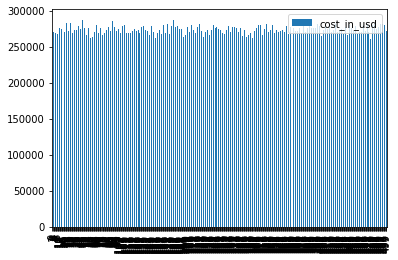

In [300]:
samples_df = pd.DataFrame(price_samples, columns=['cost_in_usd'])
samples_df.plot(kind="bar")

In [302]:
samples_df.describe().style.format('{:,}')

,cost_in_usd
count,500.0
mean,"272,789.4869023035"
std,"5,616.607766911548"
min,"254,447.36914624908"
25%,"268,907.48778797116"
50%,"272,855.14269895677"
75%,"276,912.2428068988"
max,"287,697.0390223265"


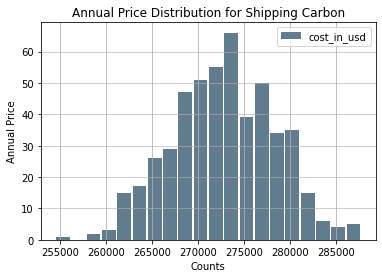

In [303]:
samples_df.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Annual Price Distribution for Shipping Carbon')
plt.xlabel('Counts')
plt.ylabel('Annual Price')
plt.grid(axis='y', alpha=0.75)

## Estimate Conversion into Facility, Transport Rates, Storage and maintenance rates at Current Values

## Cited from https://www.intechopen.com/chapters/53677

TCccs=(TFC cccs+TVC cccs)+(TFC Tccs+TVC Tccs)+(TFC sccs+TVC sccs)

Marginal cost of cabron storage = MCCCS=∂TCCCS∂QCO2

The fixed costs of carbon storage (including transportation) include the costs of pressurized transport trucks and train cars, and the costs of installing a pipeline. Fixed costs also include the costs of any equipment needed to remove captured CO2 from a truck, train car, or pipeline and inject it into NUGCs. These fixed costs can be quantified by multiplying the units of equipment (e.g., transport truck or rail car) purchased by its market price per unit. The variable costs of carbon storage include payments to labor (e.g., workers who operate and maintain trucks, trains, pipelines, and injection equipment), purchase of replacement parts, and the costs of fuel and power needed to operate and maintain trucks, trains, pipelines, and injection equipment. These variable costs can be quantified by multiplying the units employed (e.g., number of workers) or purchased (e.g., number of replacement parts) by the market wage rate for labor or the market price for replacements parts [8, 9, 13].


(1) marginal costs of carbon captured at the point of source, which range from US $200/tC to $250/tC [8]; (2) marginal costs of captured carbon transportation to storage, which range from US $5/tC to $10/tC per 100 km [8]5; and (3) marginal costs of carbon stored at the storage site, which range from US $20/tC to $55/tC

Thus, sum tranport per carbon, carbon storage at the site, and on site carbon capture is equal to 

## Tranportation Rates


In [ ]:
##